# Установка библиотек

При необходимости раскомментировать и запустить код в следующей ячейке
Иногда при установке gdal появляются проблемы, в этом случае необходимо устанавливать вручную с помощью wheel (https://opensourceoptions.com/blog/how-to-install-gdal-for-python-with-pip-on-windows/#:~:text=From%20the%20command%20prompt%20type,import%20gdal%20and%20hit%20Enter.) или с помощью conda, в случае использования соответствующих виртуальных сред

In [ ]:
# !pip install pandas
# !pip install geopandas
# !pip install pykrige
# !pip install numpy
# !pip install rasterio
# !pip install scikit-learn
# !pip install shapely
# !pip install osgeo

# Импорт библиотек

In [1]:
import warnings
warnings.filterwarnings("ignore")
import geopandas as gpd
from osgeo import gdal
from osgeo import ogr
import matplotlib.pyplot as plt  
import numpy as np 
import pandas as pd
from pykrige.rk import Krige
import rasterio
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import Affine
from shapely.geometry import box
from shapely.geometry import Polygon, Point
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import geopandas as gpd
import os
from IPython.display import clear_output
from pykrige.uk import UniversalKriging
from pykrige.ok import OrdinaryKriging

# Создание класса интерполяции

In [15]:
# создание класса интерполяции, содержащего в себе все функции и атрибуты, необходимые для проведения интерполяции
class Interpolation:
    # при инициализации объекта класса загружаются данные из указанного пользователем пути, 
    # выбирается метод интерполяции, выгружается результат интерполяции
    def __init__(self, upload_path, save_path, zfield, method = None):
        # атрибут пути для выгрузки файла, содержащего данные для интерпроляции
        self.upload_path = upload_path
        # атрибут пути для сохранения результатов интерполяции
        self.save_path = save_path
        # атрибут, содержащий массив названий переменных, которые необходимо интерполировать
        self.zfield = zfield 
        # атрибут выбранного метода интерполяции
        self.method = method
    # создание функции для проведения интерполяции методом кригинга
    def kriging(self, grid_search = True, predefined = None):
        # если пользователь не хочет производить перебор гиперпараметров, он может установить значение переменной grid_search = False и указать в перемнной predefined массив выбранных параметров
        # для проведения интерполяции необходимо использовать систему координат проекции
        proj = "+proj=aea +lat_1=34 +lat_2=40.5 +lat_0=0 +lon_0=-120 +x_0=0 +y_0=-4000000 +ellps=GRS80 +datum=NAD83 +units=m +no_defs "
        # выгрузка файла в соответствии с атрибутом класса
        gmm = gpd.read_file(self.upload_path)
        # проецирование на систему координат
        gmm = gmm.to_crs(proj)
        # создание массива координатных пар
        x_coord = gmm["geometry"].x
        y_coord = gmm["geometry"].y
        coords_moisture = [list(xy) for xy in zip(x_coord, y_coord)]
        # функция экспорта результатов интерполяции в растровый файл формата tiff
        def export_kde_raster(Z, XX, YY, min_x, max_x, min_y, max_y, proj, filename):
                # расчет разрешения на основе минимальных и максаимальных значечний
                xres = (max_x - min_x) / len(XX)
                yres = (max_y - min_y) / len(YY)
            
                # аффинное преобразование
                transform = Affine.translation(min_x - xres / 2, min_y - yres / 2) * Affine.scale(xres, yres)
            
                # экспорт массива значений в качестве растра
                with rasterio.open(
                        filename,
                        mode = "w+",
                        driver = "GTiff",
                        height = Z.shape[0],
                        width = Z.shape[1],
                        count = 1,
                        dtype = Z.dtype,
                        crs = proj_wgs,
                        transform = transform,
                ) as new_dataset:
                        new_dataset.write(Z, 1)
        # переменная-словарь для сохранения значений перебора гиперпараметров
        grid_params = {}
        # переменная-словарь для сохранения лучших значений перебора гиперпараметров
        best_grid = {}
        # цикл интерполяции для каждой указанной переменной
        for i in range(len(self.zfield)):
            # переменная-строка для хранения названия текущей переменной
            current_variable = str(self.zfield[i])
            # сохранение значений почвенной влажности в виде списка
            value_m  = list(gmm[current_variable])
            # разбиение набора данных на обучающую и тестовую выборки
            # поскольку исходный набор данных содержит всего 5 записей, объем тестовой выборки был выбран в размере 5%
            coords_m_train, coords_m_test, value_m_train, value_m_test =train_test_split(coords_moisture, value_m, test_size = 0.05, random_state = 42)        
            # создание отдельных датасетов для обучающих выборок
            m_train_gdf = gpd.GeoDataFrame(geometry = [Point(x, y) for x, y in coords_m_train], crs = proj)
            # сохранение известных значений в качестве переменной датасета
            m_train_gdf["Actual_Value"] = value_m_train
            # создание отдельных датасетов для тестовых выборок
            m_test_gdf = gpd.GeoDataFrame(geometry = [Point(x, y) for x, y in coords_m_test], crs = proj)
            # сохранение известных значений в качестве переменной датасета
            m_test_gdf["Actual_Value"] = value_m_test
            # проецирование данных в систему WGS-84 для сохранения в нужном формате
            proj_wgs = 4326
            m_train_gdf_wgs = m_train_gdf.to_crs(proj_wgs)
            m_test_gdf_wgs = m_test_gdf.to_crs(proj_wgs)
            # создание списков координатных пар в новой системе координат
            coords_train_wgs = [list(xy) for xy in zip(m_train_gdf_wgs["geometry"].x, m_train_gdf_wgs["geometry"].y)]
            coords_train_wgs = np.array(coords_train_wgs)
            coords_test_wgs = [list(xy) for xy in zip(m_test_gdf_wgs["geometry"].x, m_test_gdf_wgs["geometry"].y)]
            # сохранение максимальных и минимальных значений в новой системе координат
            min_x_wgs, min_y_wgs, max_x_wgs, max_y_wgs = m_train_gdf_wgs.total_bounds 
            # создание сетки для проецирования результатов кри
            XX_pk_krig = np.arange(min_x_wgs, max_x_wgs, 0.000002, dtype='float64')
            YY_pk_krig = np.arange(min_y_wgs, max_y_wgs, 0.000002, dtype='float64')
            # создание словаря с параметрами для перебора
            param_dict = {
                "method": ["ordinary", "universal"],
                "variogram_model": ["linear", "power", "gaussian", "spherical", "exponential"],
                "nlags": [4, 6, 8, 10, 12, 14],
            }
            # создание функции для подсчета метрик и сохранения растра
            def metric_num(to_remove = True):
                # экспорт результата интерполяции в растр
                export_kde_raster(Z = Z_pk_krig, XX = XX_pk_krig, YY = YY_pk_krig,
                       min_x = min_x_wgs, max_x = max_x_wgs, min_y = min_y_wgs, max_y = max_y_wgs,
                       proj = proj_wgs,filename = "D:/grant_data/pykrige_cv_" + str(self.zfield[i]) + ".tif")
                # выгрузка растра и его конвертация в удобный для работы формат
                raster_pk = rasterio.open("D:/grant_data/pykrige_cv_" + str(self.zfield[i]) + ".tif")
                poly_shapely = box(*raster_pk.bounds)
                attributes_df = {'Attribute': ['name1'], 'geometry': poly_shapely}
                raster_pk_extent = gpd.GeoDataFrame(attributes_df, geometry = 'geometry', crs = proj_wgs)
                # создание копий обучающих и тестовых выборок
                m_test_gdf_pk_krig = gpd.GeoDataFrame.copy(m_test_gdf)
                m_test_gdf_pk_krig = m_test_gdf_pk_krig.to_crs(proj_wgs)
                # проверка на вхождение точек в границы растрового файла
                m_test_gdf_pk_krig = m_test_gdf_pk_krig[m_test_gdf_pk_krig.within(raster_pk_extent.geometry.values[0])]
                coords_m_test_pk_krig = [list(xy) for xy in zip(m_test_gdf_pk_krig["geometry"].x, m_test_gdf_pk_krig["geometry"].y)]
                m_test_gdf_pk_krig["VALUE_Predict"] = [x[0] for x in raster_pk.sample(coords_m_test_pk_krig)]
                # генерация коэффициента детерминации вне обучающей выборки
                try:
                    out_r_squared_tp = r2_score(m_test_gdf_pk_krig.Actual_Value, m_test_gdf_pk_krig.VALUE_Predict)
                    print("PyKrige Kriging out-of-sample r-squared: {}".format(round(out_r_squared_tp, 2)))
                except:
                    raster_pk.close()
                # если пользователь предполагал проведение перебора гиперпараметров - сохраняет его результаты в словаре
                if(grid_search == True):
                    grid_params[out_r_squared_tp] = [param_dict['method'][m], param_dict['variogram_model'][v], param_dict['nlags'][n]]
                raster_pk.close()
                # удаляет результаты интерполяции с в случае, если они использовались при переборе гиперапараметров
                # временный костыль, отпадет необходимость в нем после реализации перебора гиперпараметров без сохранения файлов
                if(to_remove):
                    os.remove("D:/grant_data/pykrige_cv_" + str(self.zfield[i]) + ".tif")
                # возвращает словарь со знаечниями перебора гиперпараметров
                return grid_params
            # производит перебор гиперпараметров 
            if(grid_search == True):
                for m in range(len(param_dict['method'])):
                    for v in range(len(param_dict['variogram_model'])):
                        for n in range(len(param_dict['nlags'])):
                            if(param_dict['method'][m]=='ordinary'):
                                OK = OrdinaryKriging(
                                    np.array(coords_train_wgs[:,0:1]),
                                    np.array(coords_train_wgs[:,1:2]),
                                    value_m_train,
                                    # gmm['X'], 
                                    # gmm['Y'],
                                    # value_m,
                                    variogram_model = param_dict['variogram_model'][v],
                                    verbose = True,
                                    nlags = param_dict['nlags'][n])
                                Z_pk_krig, sigma_squared_p_krig = OK.execute("grid", XX_pk_krig, YY_pk_krig)
                            elif(param_dict['method'][m]=='universal'):
                                UK = UniversalKriging(
                                    np.array(coords_train_wgs[:,0:1]),
                                    np.array(coords_train_wgs[:,1:2]),
                                    value_m_train,
                                    # gmm['X'], 
                                    # gmm['Y'],
                                    # value_m,
                                    variogram_model = param_dict['variogram_model'][v],
                                    verbose = True,
                                    nlags = param_dict['nlags'][n]) 
                                Z_pk_krig, sigma_squared_p_krig = UK.execute("grid", XX_pk_krig, YY_pk_krig)
                            # обновляет словарь параметров полученными значениями
                            grid_params.update(metric_num(to_remove = False))
                # сохраняет лучшие гиперпараметры в словаре и выводит их
                best_params = grid_params[max(grid_params.keys())]
                best_grid[current_variable] = [best_params, max(grid_params.keys())]
            # если не была выбрана опция проведения перебора гиперпараметров - устанавливает указанные пользователем параметры в качестве лучших
            else:
                best_params = predefined
            # отчищает вывод от лишней информации
            clear_output(wait=False)
            print('Наилучшие параметры в результате перебора гиперпараметров для:')
            print(best_grid)
            # производит финальное обучение и сохранение растра интепроляции с наилучшими показателями
            if(best_params[0]=='ordinary'):
                OK = OrdinaryKriging(
                    # gmm['X'], 
                    # gmm['Y'],
                    # value_m,
                    np.array(coords_train_wgs[:,0:1]),
                    np.array(coords_train_wgs[:,1:2]),
                    value_m_train,
                    variogram_model = best_params[1],
                    verbose = True,
                    enable_plotting = True,
                    nlags = best_params[2])
                Z_pk_krig, sigma_squared_p_krig = OK.execute("grid", XX_pk_krig, YY_pk_krig)
            else:
                UK = UniversalKriging(
                    coords_train_wgs[:,0:1],
                    coords_train_wgs[:,1:2],
                    value_m_train,
                    # gmm['X'], 
                    # gmm['Y'],
                    # value_m,
                    variogram_model = best_params[1],
                    verbose = True,
                    enable_plotting = True,
                    nlags = best_params[2]) 
                Z_pk_krig, sigma_squared_p_krig = UK.execute("grid", XX_pk_krig, YY_pk_krig)
            # сохраняет результаты интерполяцици
            metric_num(to_remove = False)
            # устанавливает значение атрибута класса как "кригинг"
            self.method = 'kriging'
    # интерполяция методом обратных взвешенных расстояний   
    def idw(self):
        # переменная для хранения точек пробоотбора
        pts = ogr.Open(str(self.upload_path))
        # цикл перебора и интерполяции выборанных переменных
        for i in range(len(self.zfield)):
            # определение пути для сохранения результата интерполяции
            path = str(self.save_path + "/idw_interpolation_" + self.zfield[i] + ".tif")
            # интерполяция и сохранение растра
            idw = gdal.Grid(path, self.upload_path, zfield = self.zfield[i],
                algorithm = "invdist:power=3:radius1=2000:radius2=2000")
            idw = None
            self.method = 'idw'
    # функция отображения растра с возможностью сохранения в формате png
    def show_raster(self, to_save_or_not_to_save=False):
        for i in range(len(zfield)):
            if(self.method=='idw'):
                path = str(self.save_path + "/idw_interpolation_" + self.zfield[i] + ".tif")
            elif(self.method=='kriging'):
                path = str(self.save_path + "/pykrige_cv_" + self.zfield[i] + ".tif")
            else:
                path = None
            if(path is not None):
                data_set = gdal.Open(path)
                bands_num = data_set.RasterCount
                bands_array = []
                for j in range(bands_num):
                    bands_array.append(data_set.GetRasterBand(j+1).ReadAsArray())
                img = np.dstack(bands_array) 
                f = plt.figure(figsize=(20,6)).set_figwidth(15)
                plt.imshow(img)  
                if(to_save_or_not_to_save):
                    plt.savefig(path + '.png')
                if(self.method=='idw'):
                    plt.title("Интерполяция методом обратных взвешенных расстояний для переменной "+ zfield[i])
                elif(self.method=='kriging'):
                    plt.title("Интерполяция методом кригинга для переменной "+ zfield[i])
                plt.show()  
            else:
                print("Интерполяция не была произведена")

In [16]:
upload_path = "D:/grant_data/points_shape.shp"
save_path = "D:/grant_data"
zfield = ["w0-15","w15-30","w30-45"]
interpolated = Interpolation(upload_path=upload_path, save_path = save_path, zfield=zfield)

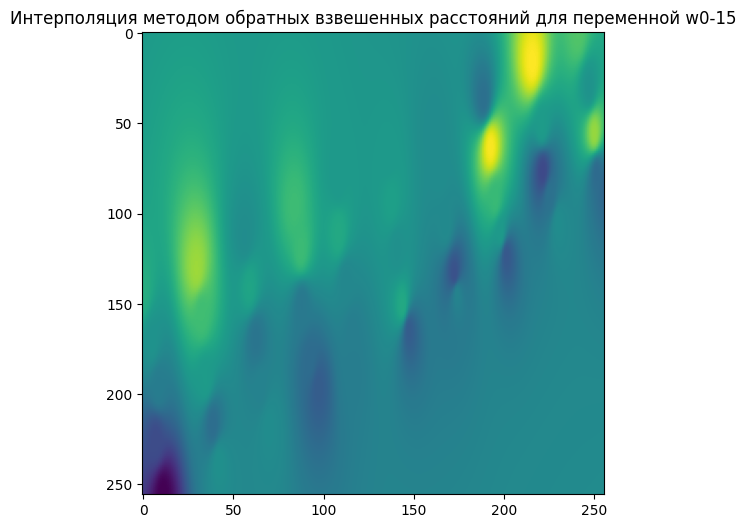

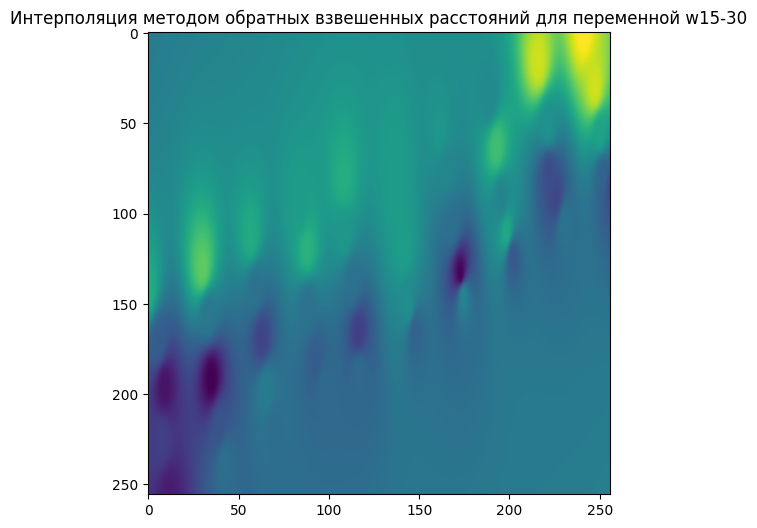

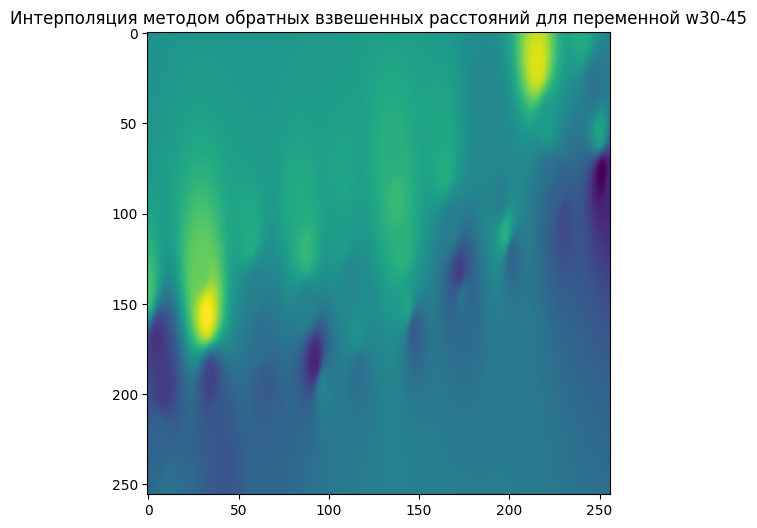

In [10]:
interpolated.idw()
interpolated.show_raster(to_save_or_not_to_save = True)

Наилучшие параметры в результате перебора гиперпараметров для:
{'w0-15': [['universal', 'spherical', 6], 0.27901215350550046], 'w15-30': [['universal', 'exponential', 8], 0.5845511827179042], 'w30-45': [['universal', 'exponential', 14], 0.5845511827179042]}
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Using 'exponential' Variogram Model
Partial Sill: 3.9330054575524995
Full Sill: 8.345154737683828
Range: 0.0014055435177924495
Nugget: 4.412149280131328 



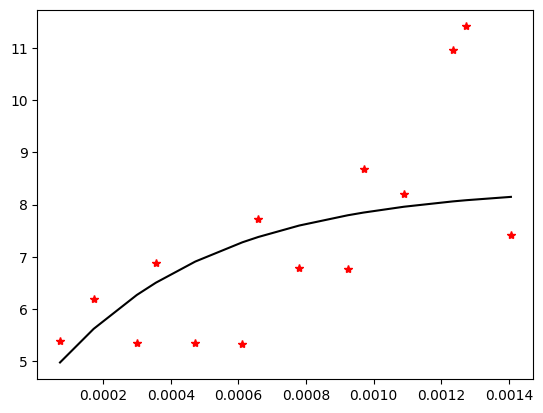

Calculating statistics on variogram model fit...
Q1 = 0.0013774984645732434
Q2 = 1.058237397230735
cR = 6.737573967894684 

Initializing drift terms...
Executing Universal Kriging...

PyKrige Kriging out-of-sample r-squared: 0.17


In [18]:
interpolated.kriging(grid_search = True)
#interpolated.show_raster(to_save_or_not_to_save = False)

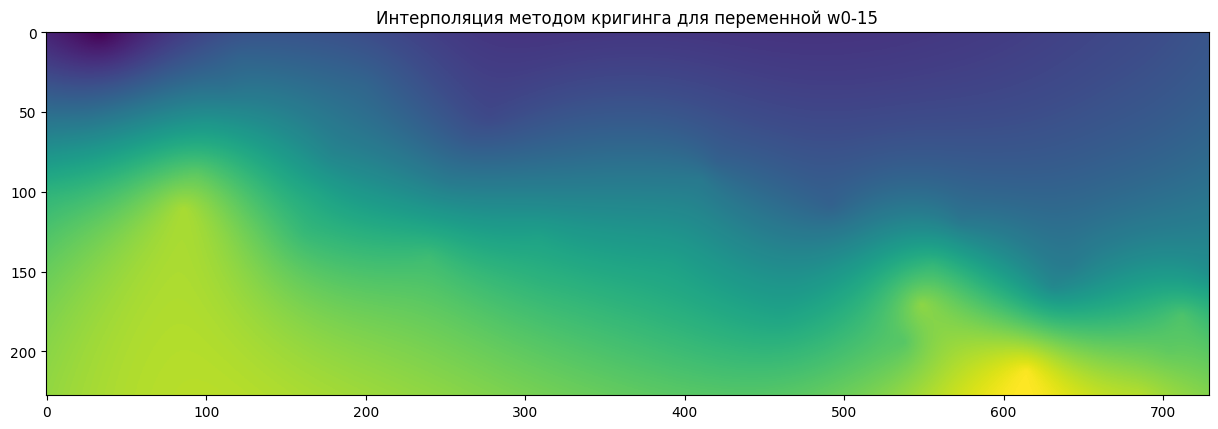

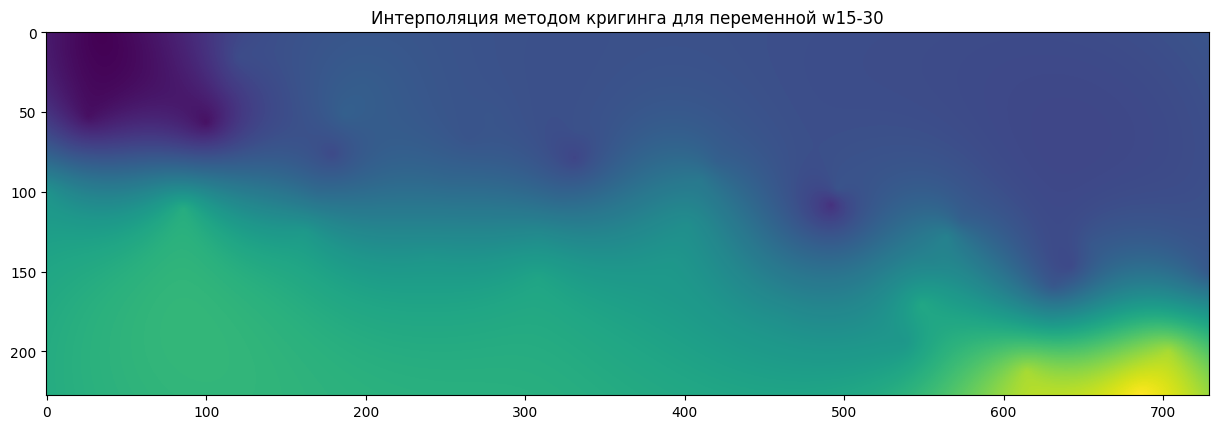

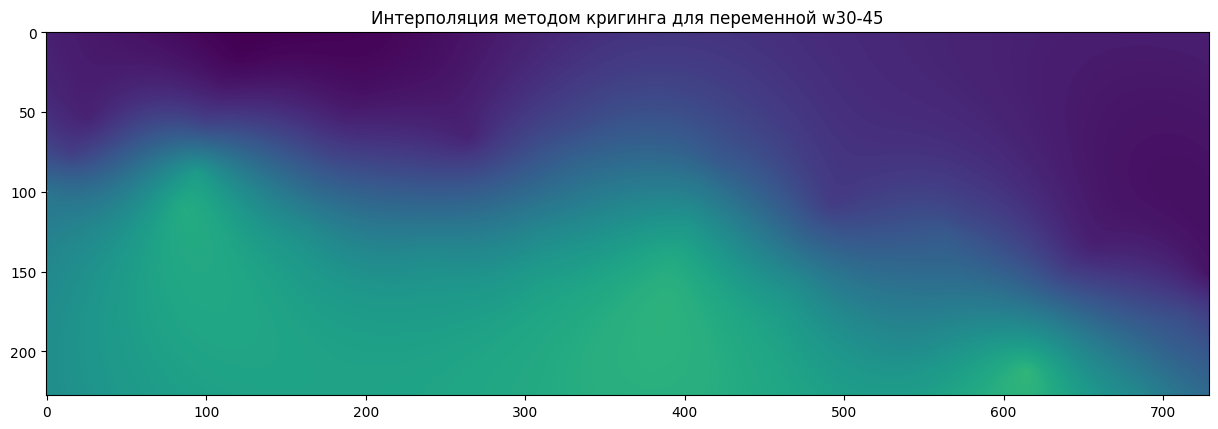

In [19]:
interpolated.show_raster(to_save_or_not_to_save = False)

In [ ]:
interpolated.kriging(grid_search = False, predefined = ['universal', 'exponential', 4])